In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import time
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_mutual_info_score, accuracy_score, homogeneity_score, silhouette_score,adjusted_rand_score,completeness_score,v_measure_score,fowlkes_mallows_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sys
from sklearn import random_projection
import warnings
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance
from sklearn.datasets import make_blobs
from scipy.stats import norm, kurtosis
#from silhouette import silhouette
from itertools import product
from sklearn.random_projection import SparseRandomProjection as RCA
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.random_projection import GaussianRandomProjection
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
matplotlib.rc('figure', figsize=[10,5])

# Read dataset

In [2]:
school = pd.read_csv('schoolpredict.csv')
print(school.dtypes)
school.head()
print(f'unique Value of our Target_class:  {school.School_Phase.unique()}')

Pupils                           int64
Girls                          float64
Boys                           float64
Gross_salary_year              float64
Total_Teachers                 float64
Total_Teaching_Assistants      float64
Non_classroom_based_support    float64
Full_Time_Teachers             float64
Pupil_Teacher_Ratio            float64
Grammer_score_AVERAGE          float64
Math_score_AVERAGE             float64
Reading_score_AVERAGE          float64
School_Phase                    object
dtype: object
unique Value of our Target_class:  ['Primary' 'Secondary' 'All through' '16 plus' 'Middle deemed secondary'
 'Middle deemed primary']


# Pre-process

In [3]:
school.isnull().sum()

Pupils                           0
Girls                            0
Boys                             0
Gross_salary_year               46
Total_Teachers                  44
Total_Teaching_Assistants       44
Non_classroom_based_support     44
Full_Time_Teachers              44
Pupil_Teacher_Ratio             44
Grammer_score_AVERAGE          917
Math_score_AVERAGE             901
Reading_score_AVERAGE          901
School_Phase                     0
dtype: int64

In [4]:
school.dropna(inplace=True)

In [5]:
school.isnull().sum()

Pupils                         0
Girls                          0
Boys                           0
Gross_salary_year              0
Total_Teachers                 0
Total_Teaching_Assistants      0
Non_classroom_based_support    0
Full_Time_Teachers             0
Pupil_Teacher_Ratio            0
Grammer_score_AVERAGE          0
Math_score_AVERAGE             0
Reading_score_AVERAGE          0
School_Phase                   0
dtype: int64

<AxesSubplot:>

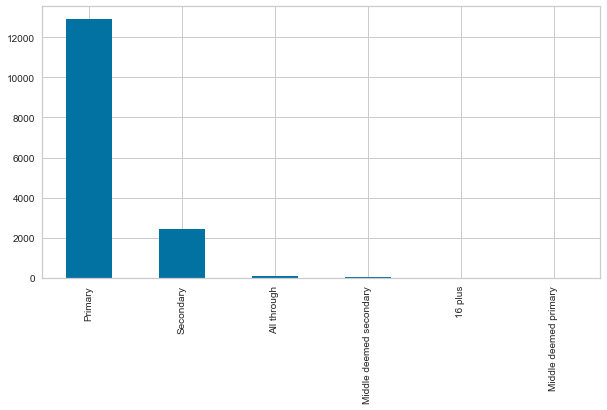

In [6]:
school['School_Phase'].value_counts().plot(kind='bar')

In [7]:
school['School_Phase'] = school['School_Phase'].map({'Primary': 1,
                                                     'Secondary' : 2,
                                                    'All through': 3,
                                                    '16 plus': 4,
                                                     'Middle deemed secondary': 5,
                                                     'Middle deemed primary': 6})



Random under-sampling:
1    6000
2    2440
3     124
5      52
4      19
6       7
Name: School_Phase, dtype: int64


<AxesSubplot:title={'center':'Count (school)'}>

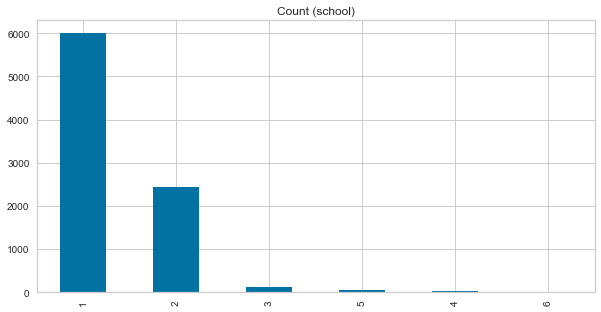

In [8]:
class_1 = school[school['School_Phase'] == 1]
class_2 = school[school['School_Phase'] == 2]
class_3 = school[school['School_Phase'] == 3]
class_4 = school[school['School_Phase'] == 4]
class_5 = school[school['School_Phase'] == 5]
class_6 = school[school['School_Phase'] == 6]

class_1_under = class_1.sample(6000, random_state = 7)
data_under = pd.concat([class_1_under, class_2, class_3,class_4, class_5, class_6], axis=0)

print('Random under-sampling:')
print(data_under.School_Phase.value_counts())

data_under.School_Phase.value_counts().plot(kind='bar', title='Count (school)')

#### Drop categorical and meaningless features

In [9]:
data_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8642 entries, 14046 to 13829
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Pupils                       8642 non-null   int64  
 1   Girls                        8642 non-null   float64
 2   Boys                         8642 non-null   float64
 3   Gross_salary_year            8642 non-null   float64
 4   Total_Teachers               8642 non-null   float64
 5   Total_Teaching_Assistants    8642 non-null   float64
 6   Non_classroom_based_support  8642 non-null   float64
 7   Full_Time_Teachers           8642 non-null   float64
 8   Pupil_Teacher_Ratio          8642 non-null   float64
 9   Grammer_score_AVERAGE        8642 non-null   float64
 10  Math_score_AVERAGE           8642 non-null   float64
 11  Reading_score_AVERAGE        8642 non-null   float64
 12  School_Phase                 8642 non-null   int64  
dtypes: float64(11

# Scaling and splitting

In [10]:
data_under.head()

Pupils  Girls  Boys  Gross_salary_year  Total_Teachers  \
14046     405   48.9  51.1            37897.0            23.0   
12988     366   51.4  48.6            38752.0            20.0   
2999      421   48.0  52.0            40685.0            20.0   
9832      244   52.0  48.0            34923.0            13.0   
10481     259   49.0  51.0            34356.0            11.0   

       Total_Teaching_Assistants   Non_classroom_based_support  \
14046                        28.0                          5.0   
12988                        12.0                          4.0   
2999                         14.0                          3.0   
9832                         20.0                          9.0   
10481                        27.0                          4.0   

       Full_Time_Teachers  Pupil_Teacher_Ratio  Grammer_score_AVERAGE  \
14046                19.2                 21.1                  103.0   
12988                17.1                 21.4                  105.0   
2999                 18.8                 22.4                  112.0   
9832                 10.3                 20.2                  106.0   
10481                10.6                 21.3                  106.0   

       Math_score_AVERAGE  Reading_score_AVERAGE  School_Phase  
14046               101.0                  101.0             1  
12988               104.0                  103.0             1  
2999                108.0                  108.0             1  
9832                105.0                  104.0             1  
10481               105.0                  105.0             1

In [11]:
X = data_under.drop('School_Phase', axis=1)
y = data_under["School_Phase"]
X_train_n, X_test_n, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

minMaxNorm = MinMaxScaler()
X_train = minMaxNorm.fit_transform(X_train_n)
X_test = minMaxNorm.fit_transform(X_test_n)

In [12]:
data_under.columns

Index(['Pupils', 'Girls', 'Boys', 'Gross_salary_year', 'Total_Teachers',
       'Total_Teaching_Assistants ', 'Non_classroom_based_support',
       'Full_Time_Teachers', 'Pupil_Teacher_Ratio', 'Grammer_score_AVERAGE',
       'Math_score_AVERAGE', 'Reading_score_AVERAGE', 'School_Phase'],
      dtype='object')

In [13]:
X_train.shape

(6913, 12)

In [14]:
LABELS = ['Pupils', 'Girls', 'Boys', 'Gross_salary_year', 'Total_Teachers',
       'Total_Teaching_Assistants ', 'Non_classroom_based_support',
       'Full_Time_Teachers', 'Pupil_Teacher_Ratio', 'Grammer_score_AVERAGE',
       'Math_score_AVERAGE', 'Reading_score_AVERAGE']

# K-means

## Elbow

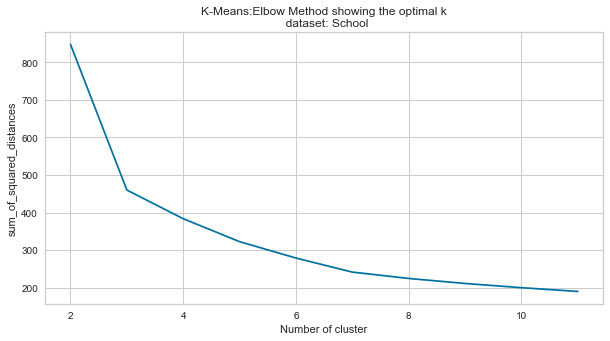

In [91]:
sse = {}
clust_range = list(range(2,12,1))
for cluster_size in clust_range:
    kmeans = KMeans(n_clusters=cluster_size, max_iter=10000, random_state=7).fit(X_train)
    sse [cluster_size] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel('sum_of_squared_distances')
plt.title('K-Means:Elbow Method showing the optimal k\n  dataset: School')
plt.show()

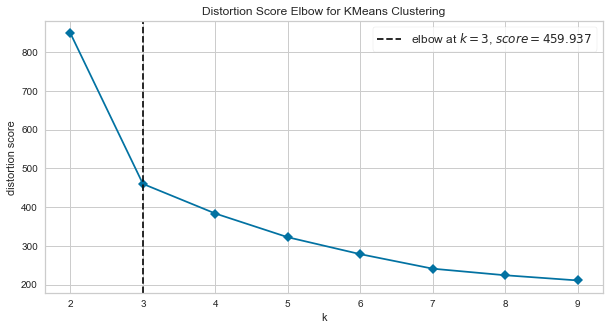

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(X_train)        
visualizer.show()     

In [93]:
kmeans = KMeans(n_clusters=3, max_iter=10000, random_state=7).fit(X_train)
print(f'adjusted_mutual_info_score based on 3 clusters :{adjusted_mutual_info_score((kmeans.labels_), y_train)}')
print(f'adjusted rand index based on 3 clusters :{adjusted_rand_score((kmeans.labels_), y_train)}')
print(f'homogeneity_score based on 3 clusters :{homogeneity_score((kmeans.labels_), y_train)}')
print(f'completeness_score based on 3 clusters :{completeness_score((kmeans.labels_), y_train)}')
print(f'v_measure_score based on 3 clusters :{v_measure_score((kmeans.labels_), y_train)}')
print(f'fowlkes_mallows_score based on 3 clusters :{fowlkes_mallows_score((kmeans.labels_), y_train)}')


adjusted_mutual_info_score based on 3 clusters :0.5080856033161469
adjusted rand index based on 3 clusters :0.6562241849315501
homogeneity_score based on 3 clusters :0.538648913243183
completeness_score based on 3 clusters :0.4817363783552127
v_measure_score based on 3 clusters :0.5086054822767304
fowlkes_mallows_score based on 3 clusters :0.8586424079934845


## Metrics

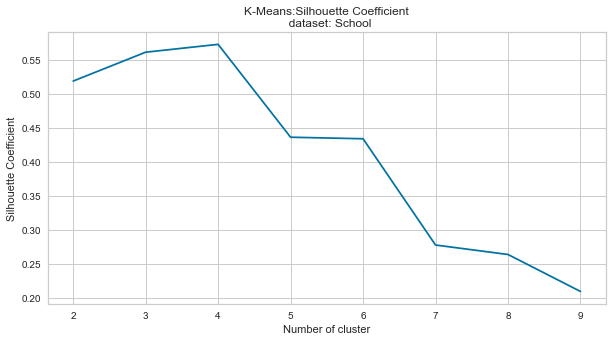

In [94]:
silh = {}
homog = {}
for cluster_size in range(2,10):
    kmeans = KMeans(n_clusters=cluster_size, max_iter=10000, random_state=7).fit(X_train)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_train, label, metric='euclidean')
    homog_score = homogeneity_score(y_train, label)
    silh[cluster_size] = sil_coeff
    homog[cluster_size] = homog_score
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()),'bx-' )
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.title('K-Means:Silhouette Coefficient\n  dataset: School')
plt.show()

In [95]:
def get_kmean_scores(X, y, N):


    def get_kmean(n):
        km = KMeans(n_clusters=n,random_state=7, max_iter=10000)
        km.fit(X)
        km_labels = km.predict(X)
        
        hom = homogeneity_score(y, km_labels)
        ami = adjusted_mutual_info_score(y,km_labels)
        rand = adjusted_rand_score(y,km_labels)
        comple = completeness_score(y,km_labels)
        vmeasure = v_measure_score(y,km_labels)
        fowm = fowlkes_mallows_score(y, km_labels)
        
        
        return hom, ami, rand, comple, vmeasure, fowm 
    
  
    
    n_rng = np.arange(2,N+1)
    scores_df = pd.DataFrame()

    for n in n_rng:
        results = {'n':n}
        hom, ami, rand, comple, vmeasure, fowm  = get_kmean(n)            
        results[f"hom"] = hom; results[f"ami"] = ami; results[ f"rand"] = rand; results[f"comple"] = comple; results[f"vmeasure"] = vmeasure; results[f"fowm"] = fowm 
        print(f" done with N: {n}")
        
        scores_df = scores_df.append(results, ignore_index=True)
            

    return scores_df

In [96]:
def plot_elbow_kmeans(k_metric_df, name='dsname'):
    
    #fig = plt.figure(figsize=[2,3])

    plt.figure()
    
    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')
    
    plt.plot(x_vals, k_metric_df['hom'], label="Homogeneity")
    plt.plot(x_vals, k_metric_df['ami'], label="AMI")
    plt.plot(x_vals, k_metric_df['rand'], label="Rand index")
    plt.plot(x_vals, k_metric_df['comple'], label="Completeness")
    plt.plot(x_vals, k_metric_df['vmeasure'], label="V-measure")
    plt.plot(x_vals, k_metric_df['fowm'], label="Fowlkes-Mallows")

    plt.legend()
    plt.xlabel("Number of cluster")
    plt.ylabel("scores")
    plt.title('K-Means:other performance evaluation\n dataset: %s '%name)
    plt.show()

In [97]:
scores_df = get_kmean_scores(X_train, y_train, 10)

 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10


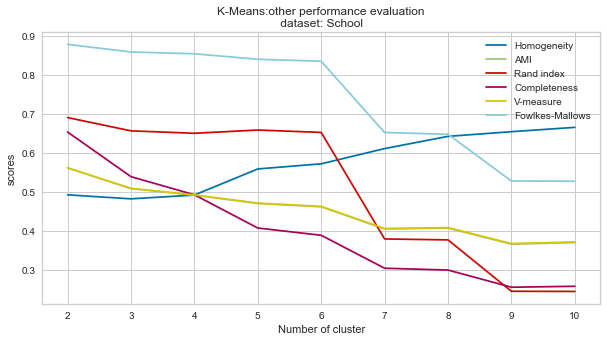

In [98]:
plot_elbow_kmeans(scores_df, 'School')

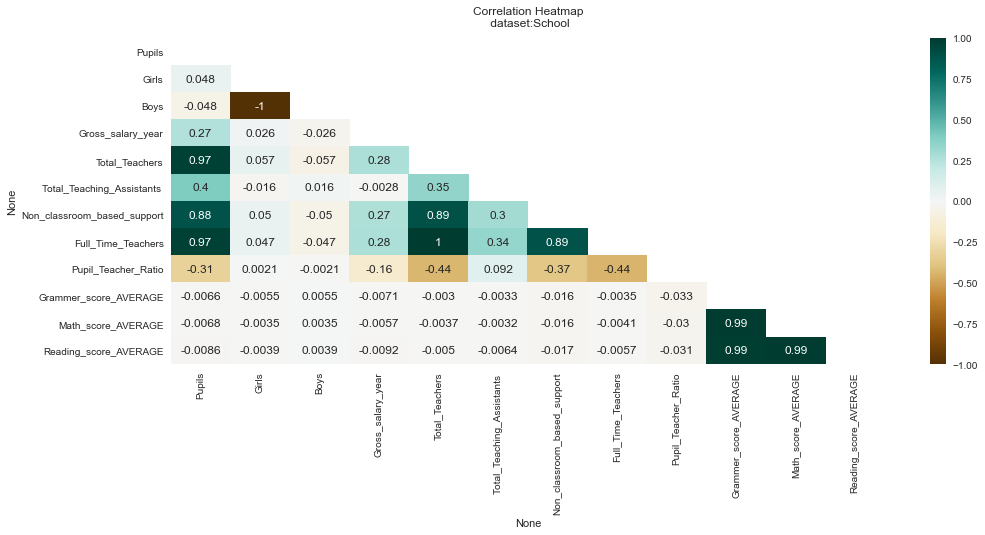

In [100]:
##Point Biserial Correlation
from scipy import stats
pair_corr = pd.DataFrame(X_train, columns=[LABELS])


num_corr=pair_corr.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(num_corr, dtype=np.bool))
num_heatmap = sns.heatmap(num_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
num_heatmap.set_title('Correlation Heatmap\n dataset:School', fontdict={'fontsize':12}, pad=12);

Text(0.5, 1.08, 'Kmeans: pairwise plotting, k-cluster = 3\n dataset: School')

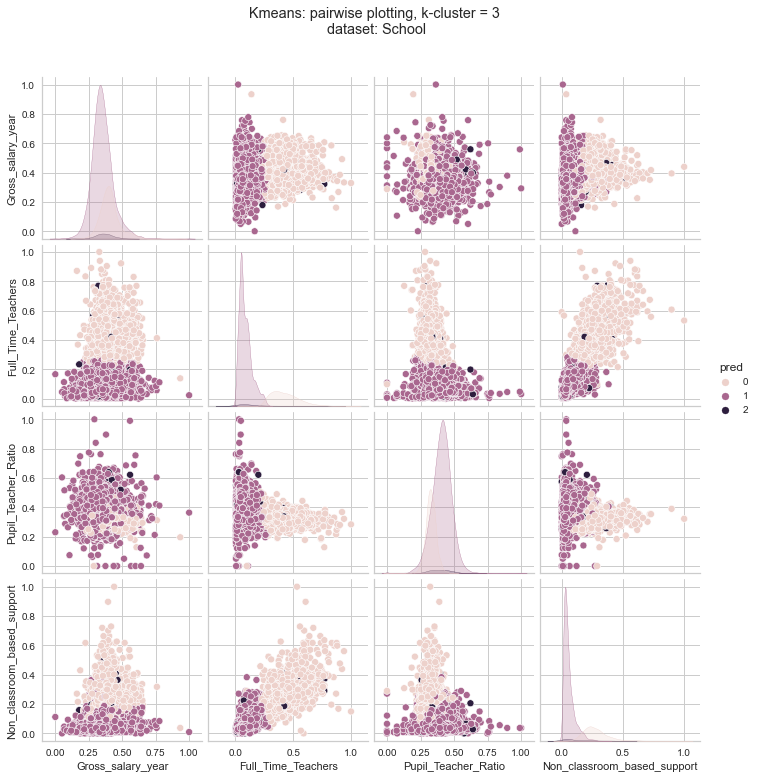

In [104]:
#Kmeans Pairwise
pair_df = pd.DataFrame(X_train, columns=LABELS)

km = KMeans(n_clusters=3,random_state=7, max_iter=10000)
km.fit(X_train)
labels = km.labels_
pred_clusters = km.predict(X_train)
pred_clusters.shape

filtred_df = pair_df.filter(['Gross_salary_year',
        'Full_Time_Teachers','Pupil_Teacher_Ratio', 'Non_classroom_based_support'], axis=1)

filtred_df['pred'] = labels #pred_mal_clusters
ax = sns.pairplot(filtred_df, hue="pred")
ax.fig.suptitle("Kmeans: pairwise plotting, k-cluster = 3\n dataset: School", y=1.08)


Text(0.5, 1.08, 'Ground truth labels: pairwise plotting, k-cluster = 6\n dataset: School')

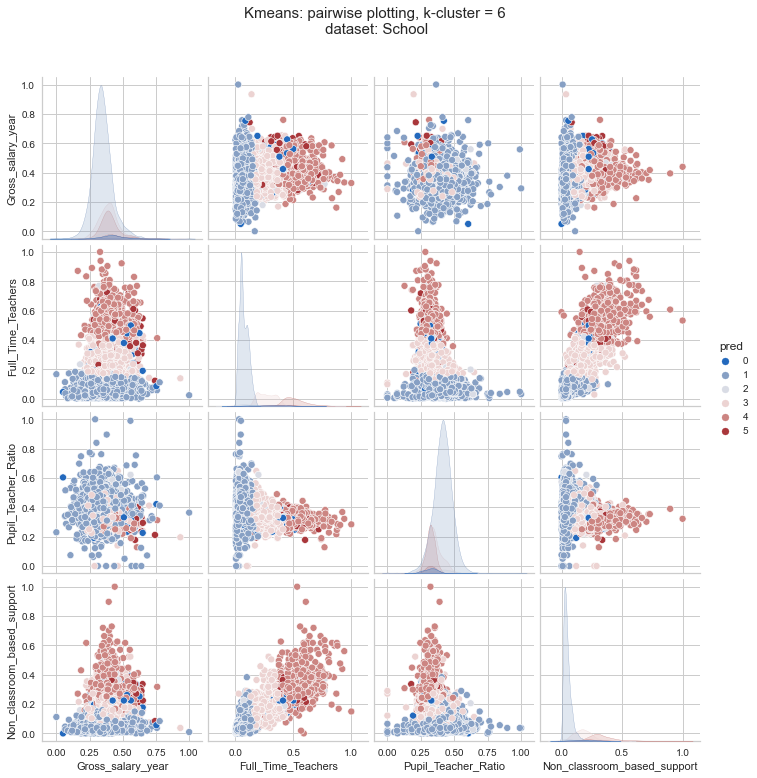

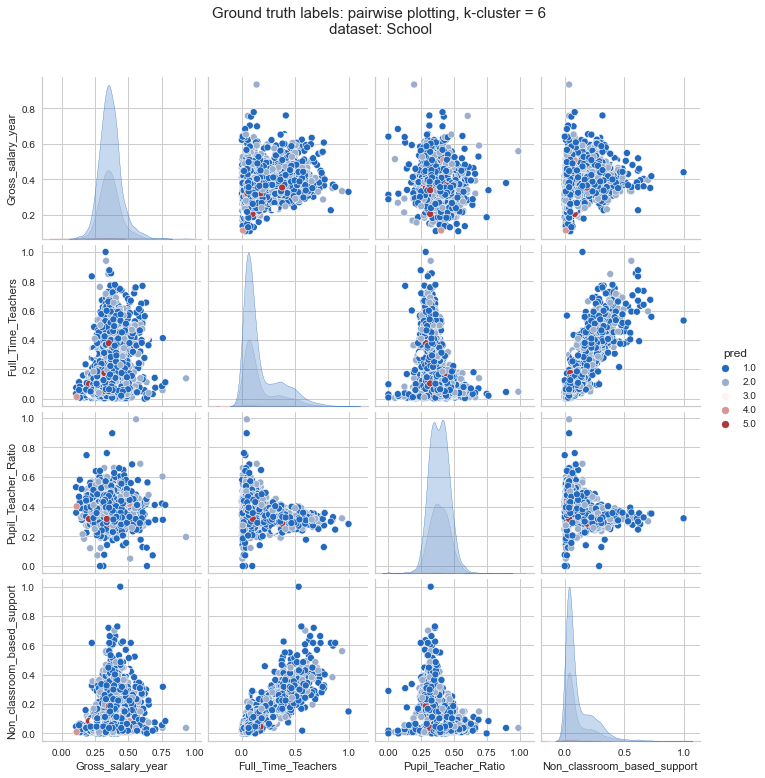

In [214]:
pair_df = pd.DataFrame(X_train, columns=LABELS)
#Kmeans Pairwise
km = KMeans(n_clusters=6,random_state=7, max_iter=10000 )
km.fit(X_train)
labels = km.labels_
pred_clusters = km.predict(X_train)
pred_clusters.shape

filtred_df = pair_df.filter(['Gross_salary_year',
        'Full_Time_Teachers','Pupil_Teacher_Ratio', 'Non_classroom_based_support'], axis=1)


'''
Comparing if the k-means clustering is natually lining up or not with the actual ground truth, just use K=2 
and do pairwise with a few important columns
'''

#USE K=2 k-mean prediction
filtred_df['pred'] = pred_clusters
ax = sns.pairplot(filtred_df, hue="pred", palette = 'vlag' )
ax.fig.suptitle("Kmeans: pairwise plotting, k-cluster = 6\n dataset: School", y=1.08, fontsize=15)

#USING ground truth y-values
filtred_df['pred'] = y_train 
ax = sns.pairplot(filtred_df, hue="pred", palette = 'vlag' )
ax.fig.suptitle("Ground truth labels: pairwise plotting, k-cluster = 6\n dataset: School", y=1.08, fontsize=15)


# EM

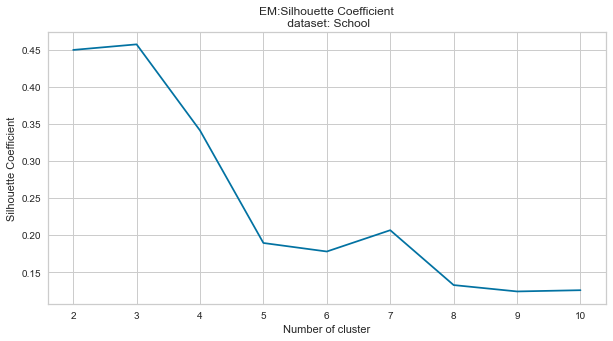

In [16]:
# Churn dataset on EM
silh_em = {}
homog_em = {}
ll_em = {}
for cluster in range(2,11):
    gmm = GaussianMixture(n_components=cluster, max_iter=10000, random_state=7, 
                          n_init=5).fit(X_train)
    label = gmm.predict(X_train)
    sil_coeff = silhouette_score(X_train, label, metric='euclidean')
    homog_score = homogeneity_score(y_train, label)
    silh_em[cluster] = sil_coeff
    homog_em[cluster] = homog_score
    ll_em[cluster] = gmm.score(X_test)
plt.figure()
plt.plot(list(silh_em.keys()), list(silh_em.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.title("EM:Silhouette Coefficient\n dataset: School")
plt.show()

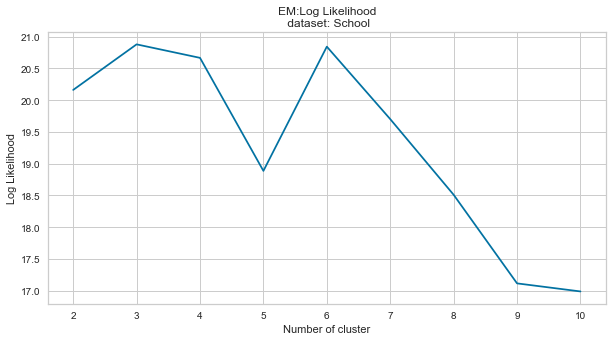

In [17]:
plt.figure()
plt.plot(list(ll_em.keys()), list(ll_em.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Log Likelihood")
plt.title("EM:Log Likelihood\n dataset: School")
plt.show()

In [107]:
def get_em_results_names():
    cv_types = ["spherical", "tied", "diag", "full"]
    score_types = ["sil","bic","hom", "fowm", "ami"]
    names = [f"{sc}_{cv}" for sc in score_types for cv in cv_types] 
    return names



def get_em_scores(X, y, N):


    def get_em(n, cv_t):
        gmm = GMM(n_components=n, covariance_type=cv_t, warm_start=True, random_state=7)
        gmm.fit(X)
        gmm_labels = gmm.predict(X)

        ss = silhouette_score(X, gmm_labels, metric='euclidean')
        bic = gmm.bic(X)
        hom = homogeneity_score(y, gmm_labels)
        fowm = fowlkes_mallows_score(y, gmm_labels)
        ami = adjusted_mutual_info_score(y,gmm_labels)
        return ss, bic, hom, fowm, ami
    
    cv_types = ["spherical", "tied", "diag", "full"]
        
    
    n_rng = np.arange(2,N+1)
    
    names =['n'] + get_em_results_names()

    scores_df = pd.DataFrame(columns=names)

    for n in n_rng:
        results = {'n':n}
        for cv_t in cv_types:
            ss_em, bic, hom, fowm, ami = get_em(n,cv_t)            
            results[ f"sil_{cv_t}"] =  ss_em; results[f"bic_{cv_t}"] = bic ; results[f"hom_{cv_t}"] = hom; results[f"fowm_{cv_t}"] = fowm; results[f"ami_{cv_t}"] = ami
        print(f" done with N: {n}")
        
        scores_df = scores_df.append(results, ignore_index=True)
            

    return scores_df

In [108]:
def plot_elbow_em(k_metric_df, name='dsname', face_color=None):
    
    figsave=False
    
    
    fig = plt.figure(figsize=[20,5])
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    allAxs = [ax1, ax2, ax3, ax4, ax5] 

    
    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')

    for cv_t in ["spherical", "tied", "diag", "full"]:
        
        ax1.plot(x_vals, k_metric_df['sil_'+cv_t], label=f"{cv_t}")
        ax2.plot(x_vals, k_metric_df['bic_'+cv_t], label=f"{cv_t}")
        ax3.plot(x_vals, k_metric_df['hom_'+cv_t], label=f"{cv_t}")
        ax4.plot(x_vals, k_metric_df['fowm_'+cv_t], label=f"{cv_t}")
        ax5.plot(x_vals, k_metric_df['ami_'+cv_t], label=f"{cv_t}")
   
    ax1.set_xticks(x_vals); ax2.set_xticks(x_vals); ax3.set_xticks(x_vals); ax4.set_xticks(x_vals);ax5.set_xticks(x_vals)
    
    if face_color != None:
        for ax in allAxs:
            ax.set_facecolor(face_color)

    ax1.legend(); ax1.set_ylabel("Silhouette Score"); ax1.set_xlabel("Number of cluster");ax1.grid(True)
    ax2.legend(); ax2.set_ylabel("Bic Score"); ax2.set_xlabel("Number of cluster");ax2.grid(True)
    ax3.legend(); ax3.set_ylabel("Homogeneity Score"); ax3.set_xlabel("Number of cluster"); ax3.grid(True)
    ax4.legend(); ax4.set_ylabel("Fowlkes-Mallows Score"); ax4.set_xlabel("Number of cluster"); ax4.grid(True)
    ax5.legend(); ax5.set_ylabel("AMI Score"); ax5.set_xlabel("Number of cluster"); ax5.grid(True)

    ax1.set_title('EM: Elbow silhouette score\n  dataset: %s '%name)
    ax2.set_title('EM: BIC score\n  dataset: %s '%name)
    ax3.set_title('EM: Homogeneity score\n  dataset: %s '%name)
    ax4.set_title('EM: Fowlkes-Mallows score\n  dataset: %s '%name)
    ax5.set_title('EM: Ajusted Mutual Information score\n  dataset: %s '%name)



    fig.tight_layout()
    plt.show()

    #if figsave:
    #    fig.savefig('plots/em_cov_%s_results.png'%short_name, bbox_inches='tight')
    #    plt.close(fig=fig)
    #else:
    #    plt.show()

In [109]:
scores_x = get_em_scores(X_train, y_train, 10)

 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10


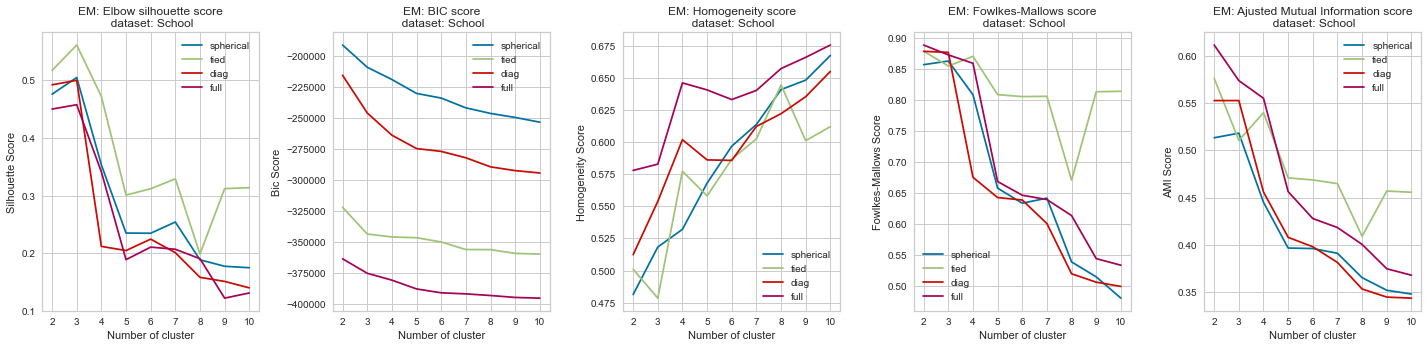

In [110]:
plot_elbow_em(scores_x, 'School')

In [111]:
kmeans = KMeans(n_clusters=5, max_iter=10000, random_state=3).fit(X_train)
print(f'adjusted_mutual_info_score based on 3 clusters :{adjusted_mutual_info_score((kmeans.labels_), y_train)}')
print(f'adjusted rand index based on 3 clusters :{adjusted_rand_score((kmeans.labels_), y_train)}')
print(f'homogeneity_score based on 3 clusters :{homogeneity_score((kmeans.labels_), y_train)}')
print(f'completeness_score based on 3 clusters :{completeness_score((kmeans.labels_), y_train)}')
print(f'v_measure_score based on 3 clusters :{v_measure_score((kmeans.labels_), y_train)}')
print(f'fowlkes_mallows_score based on 3 clusters :{fowlkes_mallows_score((kmeans.labels_), y_train)}')

adjusted_mutual_info_score based on 3 clusters :0.467650183692381
adjusted rand index based on 3 clusters :0.6520345400516474
homogeneity_score based on 3 clusters :0.4030712609216793
completeness_score based on 3 clusters :0.5593853342699115
v_measure_score based on 3 clusters :0.46853469164577716
fowlkes_mallows_score based on 3 clusters :0.8359084225355639


Text(0.5, 1.08, 'EM: pairwise plotting, k-cluster = 3\n dataset: School')

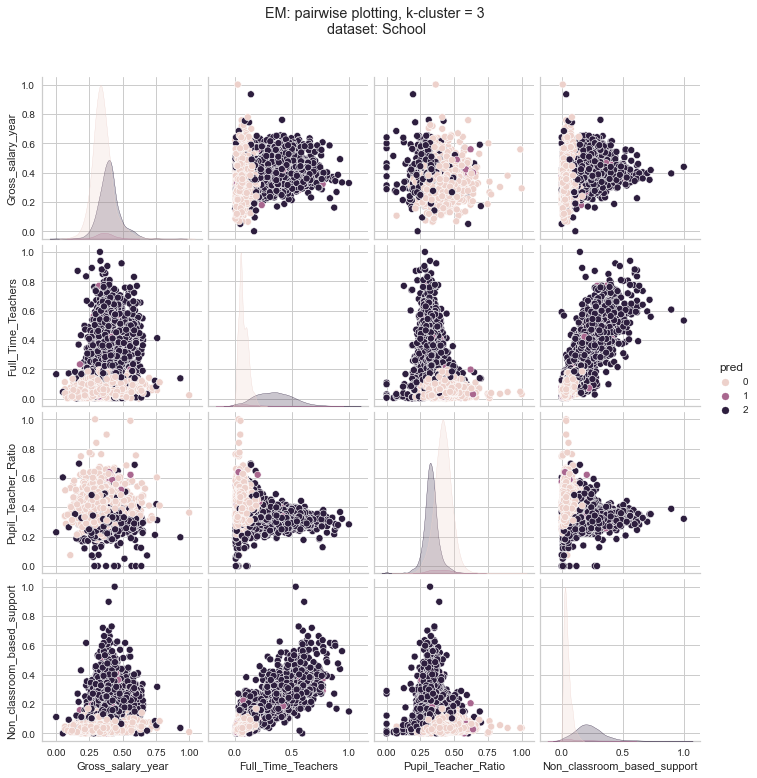

In [113]:

gmm = GMM(n_components=3, covariance_type='full', random_state=998756)
gmm.fit(X_train)
#labels2 = gmm.labels_

pred_clusters = gmm.predict(X_train)


filtred_df2 = pair_df.filter(['Gross_salary_year',
        'Full_Time_Teachers','Pupil_Teacher_Ratio', 'Non_classroom_based_support'], axis=1)

filtred_df2['pred'] = pred_clusters #pred_mal_clusters
ax = sns.pairplot(filtred_df2, hue="pred")
ax.fig.suptitle("EM: pairwise plotting, k-cluster = 3\n dataset: School", y=1.08)


Text(0.5, 1.08, 'Ground truth labels: pairwise plotting, k-cluster = 6\n dataset: School')

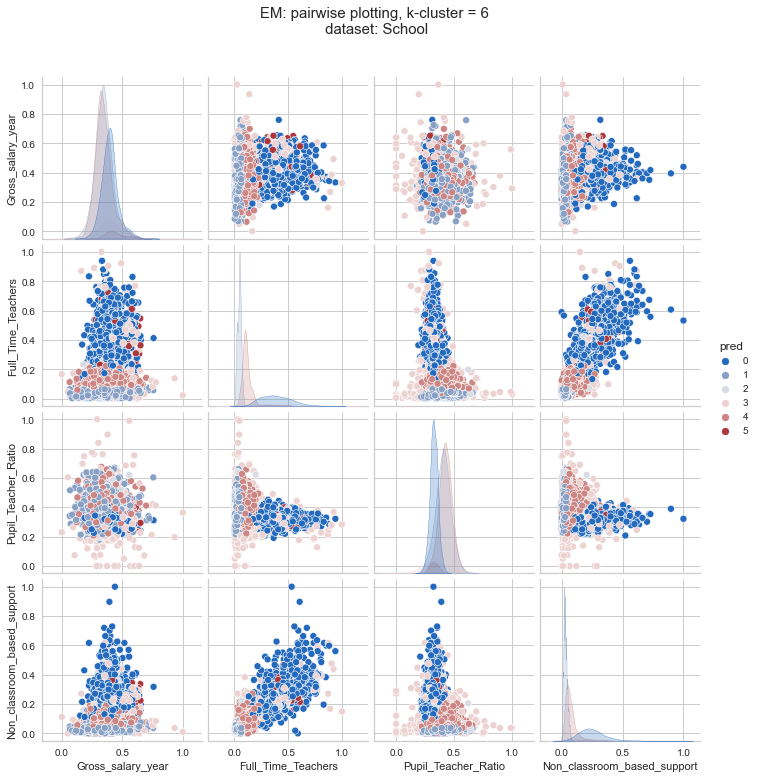

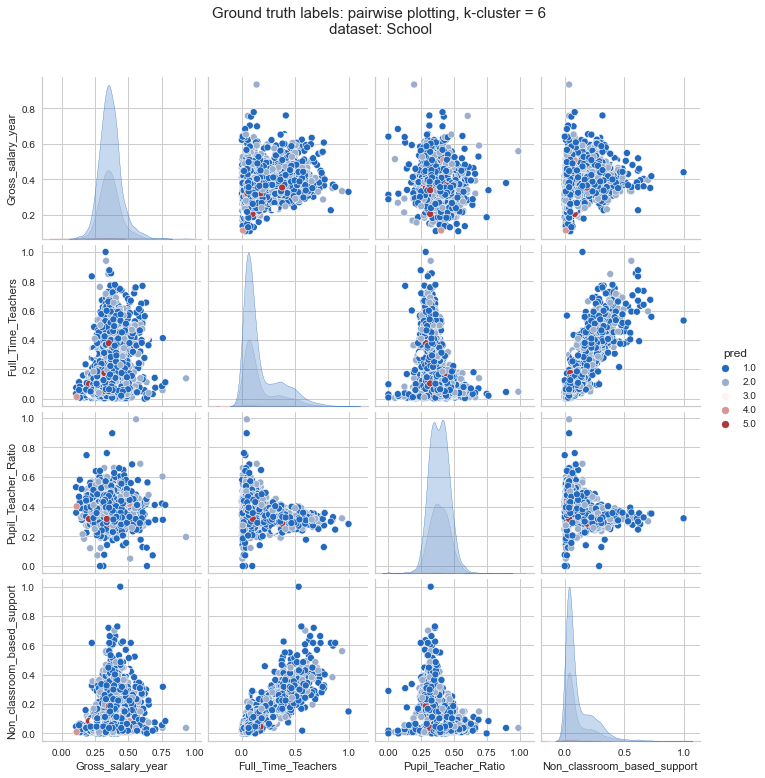

In [215]:
pair_df = pd.DataFrame(X_train, columns=LABELS)
#EM Pairwise
gmm = GMM(n_components=6, covariance_type='full', random_state=7)
gmm.fit(X_train)
pred_clusters = gmm.predict(X_train)

filtred_df = pair_df.filter(['Gross_salary_year',
        'Full_Time_Teachers','Pupil_Teacher_Ratio', 'Non_classroom_based_support'], axis=1)


'''
Comparing if the em clustering is natually lining up or not with the actual ground truth, just use K=2 
and do pairwise with a few important columns
'''

#USE K=2 em prediction
filtred_df['pred'] = pred_clusters
ax = sns.pairplot(filtred_df, hue="pred", palette = 'vlag' )
ax.fig.suptitle("EM: pairwise plotting, k-cluster = 6\n dataset: School", y=1.08, fontsize=15)

#USING ground truth y-values
filtred_df['pred'] = y_train 
ax = sns.pairplot(filtred_df, hue="pred", palette = 'vlag' )
ax.fig.suptitle("Ground truth labels: pairwise plotting, k-cluster = 6\n dataset: School", y=1.08, fontsize=15)

# Feature Reduction

## PCA

In [138]:
pca1 = PCA(random_state=7)
pca1.fit(X_train)
pca_ind = pca1.explained_variance_ratio_
print(pca_ind)

[4.65541275e-01 3.10797442e-01 1.13362613e-01 4.33079957e-02
 3.01137840e-02 2.12065450e-02 1.12001669e-02 2.49862523e-03
 8.56184993e-04 5.90157290e-04 5.25196853e-04 1.42425621e-08]


In [139]:
pca_cumsum = pca1.explained_variance_ratio_.cumsum()
print(pca_cumsum)

[0.46554127 0.77633872 0.88970133 0.93300933 0.96312311 0.98432965
 0.99552982 0.99802845 0.99888463 0.99947479 0.99999999 1.        ]


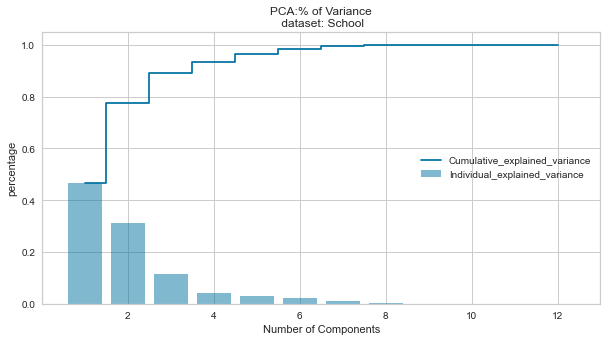

In [140]:
plt.bar(range(1, 13), pca_ind, alpha=0.5, align='center', label='Individual_explained_variance')  
plt.step(range(1, 13), pca_cumsum, where='mid', label='Cumulative_explained_variance') 
plt.ylabel("percentage")
plt.xlabel("Number of Components")
plt.title("PCA:% of Variance\n dataset: School")
plt.legend(loc='right')
plt.show()

In [150]:
pca1.explained_variance_ratio_[:4
                             ].sum()

0.9330093254646967

In [15]:
pca1 = PCA(n_components=4,random_state=7)
pca1.fit(X_train)
pca_X =pca1.transform(X_train)

In [16]:
import seaborn as sns

def plot_pca(vector_num,top_comp):
    v_1 = pca1.components_[vector_num]
    comps = pd.DataFrame(list(zip(v_1, X.columns.values)), 
                             columns=['weights', 'features'])
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(top_comp)
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features",
                   color = "C0"
                   #palette="pastel"
                  )
    ax.set_title("PCA:Component Analyzation,Component #" + str(vector_num) + "\n dataset: School")
    plt.show()

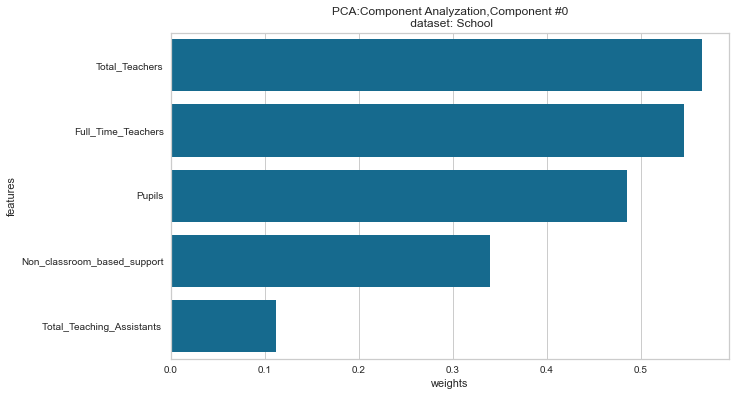

In [17]:
plot_pca(0,5)

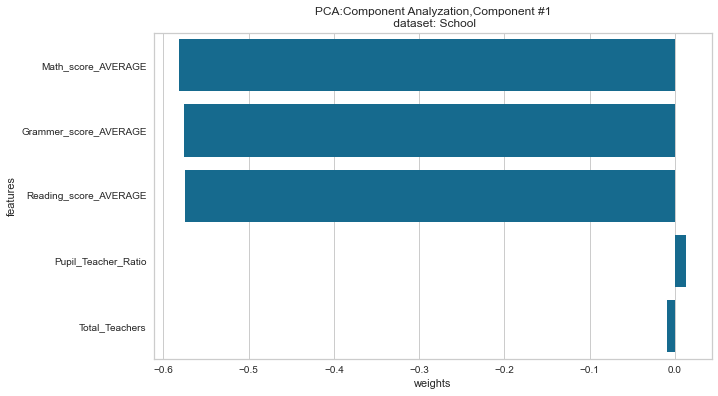

In [18]:
plot_pca(1,5)

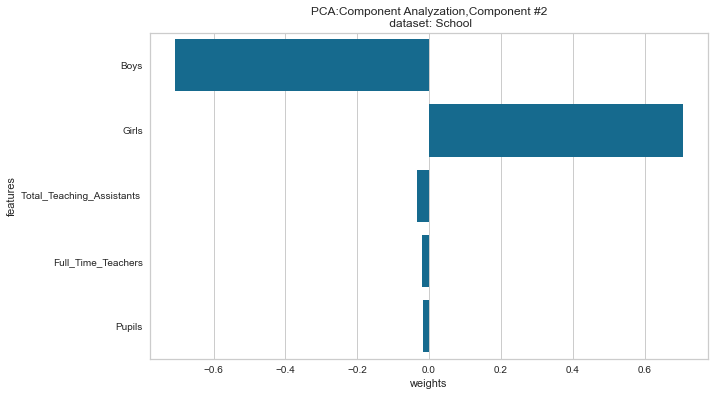

In [19]:
plot_pca(2,5)

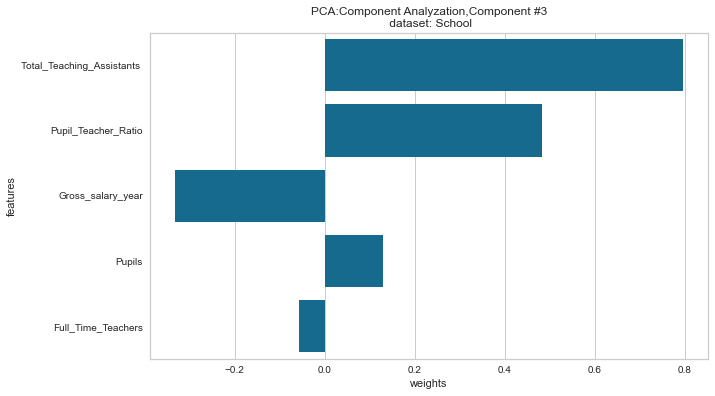

In [20]:
plot_pca(3,5)

In [130]:
def pca(X, cutoff_per, var_threashold):
    pca = PCA(cutoff_per, random_state=7)
    pca.fit(X)
    pca.explained_variance_

    row_index = range(1, pca.explained_variance_.shape[0] + 1)
    ev = pd.Series(data=pca.explained_variance_, index=row_index)
    evr = pd.Series(data=pca.explained_variance_ratio_, index=row_index)
    eigen = pd.Series(data=pca.singular_values_, index=row_index)  
    
    pca_stats_df = pd.DataFrame()
    pca_stats_df['pca_stats_df'] = ev
    pca_stats_df['e-variance-ratio'] = evr
    pca_stats_df['eigen'] = eigen

    var_above = pca_stats_df[pca_stats_df['pca_stats_df'] >= var_threashold]
    #print(pca_stats_df)
    print("Original PCA components")
    print(pca_stats_df)
    print(f"Threshold PCA components variance >= [{var_threashold:.2f}%]")
    print(var_above)
  
    constrained_cols = var_above.index-1
    X_pca_projected = pca.transform(X)

    return pd.DataFrame(X_pca_projected).filter(constrained_cols, axis=1)

In [157]:
print(f"\n---- RUNNING PCA -------")
X_pca_proj_test = pca(X_train, 0.9, 0.02)


---- RUNNING PCA -------
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.089568          0.465541  24.881646
2      0.059796          0.310797  20.330063
3      0.021811          0.113363  12.278207
4      0.008332          0.043308   7.588991
Threshold PCA components variance >= [0.02%]
   pca_stats_df  e-variance-ratio      eigen
1      0.089568          0.465541  24.881646
2      0.059796          0.310797  20.330063
3      0.021811          0.113363  12.278207


## ICA

In [135]:
ks = [1,2,3,4,5,6,7,8,9,10,11,12]
def find_ica(ks,X):
    results = []
    for k in ks:
        transformerlarge = FastICA(n_components=k,
                random_state=0)
        X_transformed_large = transformerlarge.fit_transform(X)
        results.append(kurtosis(X_transformed_large))#.mean()
    return results

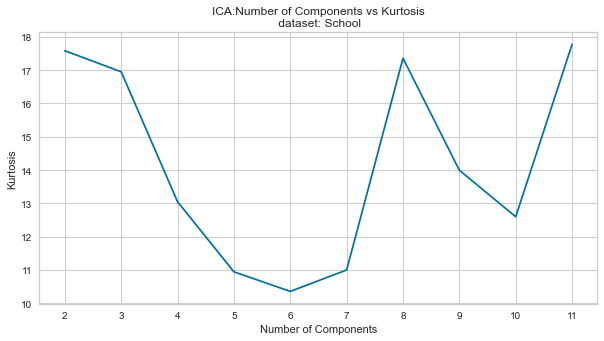

In [158]:
ks = range(2,12)
results = find_ica(ks,X_train)
rs = []
for r in results:
    rs.append(r.mean())
plt.title('ICA:Number of Components vs Kurtosis\n dataset: School')
plt.xlabel('Number of Components')
plt.ylabel('Kurtosis')
plt.xticks(range(10),ks)
plt.plot(rs)

In [159]:
should_whiten = True
transformerlarge = FastICA(n_components=2,
                random_state=7, whiten=should_whiten, max_iter=10000)
X_transformed_large = transformerlarge.fit_transform(X_train)


In [160]:
def plot_ica(vector_num,top_comp,transformerlarge=transformerlarge):
    v_1 = transformerlarge.components_[vector_num]
    comps = pd.DataFrame(list(zip(v_1, X.columns.values)), 
                             columns=['weights', 'features'])
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(top_comp)
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   color = "C0",
                   #palette="Blues_d"
                  )
    ax.set_title("ICA Component Makeup, Component #" + str(vector_num) +"\n dataset: Satisfaction")
    plt.show()

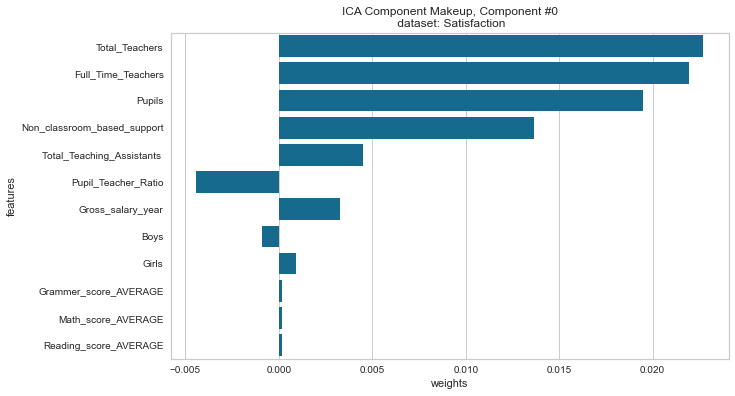

In [162]:
plot_ica(0,12)

In [163]:
def max_kurtosis_indexes(X_projected, cutoff):
    tmp = pd.DataFrame(X_projected)
    tmp = tmp.kurt(axis=0)
    kurt = tmp.sort_values(ascending=False)
        
    max_k = kurt[0:cutoff]
    print(f"Top-{cutoff} Max Kurtosis -- ")
    print(max_k)
    print(max_k.index)
    return max_k.index

In [164]:
def ica_max_kurtosis(X, cutoff, dim=0):

    if dim == 0:
        dim = X.shape[1]-1
    elif dim < cutoff:
        dim = cutoff

    ica = FastICA(random_state=7)
    ica.set_params(n_components=dim)
    X_projected = ica.fit_transform(X)

    max_k_idexes = max_kurtosis_indexes(X_projected,cutoff)
    
    X_proj_df = pd.DataFrame(X_projected)
    X_proj_df  = X_proj_df.filter( max_k_idexes, axis=1 )
        
    return X_proj_df

In [165]:
def ica_research(X, dim, cutoff):
    should_whiten = True
    ica = FastICA(dim, random_state=7, whiten=should_whiten, max_iter=10000)
    S_ = ica.fit_transform(X)
    A_ = ica.mixing_
    C_ = ica.components_
    
    max_k_idexes = max_kurtosis_indexes(S_,cutoff)
    
    mean_ = ica.mean_ if should_whiten else 0
    print(f"X.shape = {X.shape}")
    C_filtered = pd.DataFrame(C_).filter( max_k_idexes, axis=0)
    return A_, C_, C_filtered, mean_

In [172]:
A_ , C_, C_filtered, mean_ = ica_research(X_train, 8, 4)

Top-4 Max Kurtosis -- 
2    38.776912
3    33.834487
6    15.669273
4    13.869148
dtype: float64
Int64Index([2, 3, 6, 4], dtype='int64')
X.shape = (6913, 12)


In [173]:
A_ , C_, C_filtered, mean_ = ica_research(X_train, 2, 2)

Top-2 Max Kurtosis -- 
1    33.829380
0     1.364244
dtype: float64
Int64Index([1, 0], dtype='int64')
X.shape = (6913, 12)


Top-4 Max Kurtosis -- 
2    38.776912
3    33.834487
6    15.669273
4    13.869148
dtype: float64
Int64Index([2, 3, 6, 4], dtype='int64')
X.shape = (6913, 12)


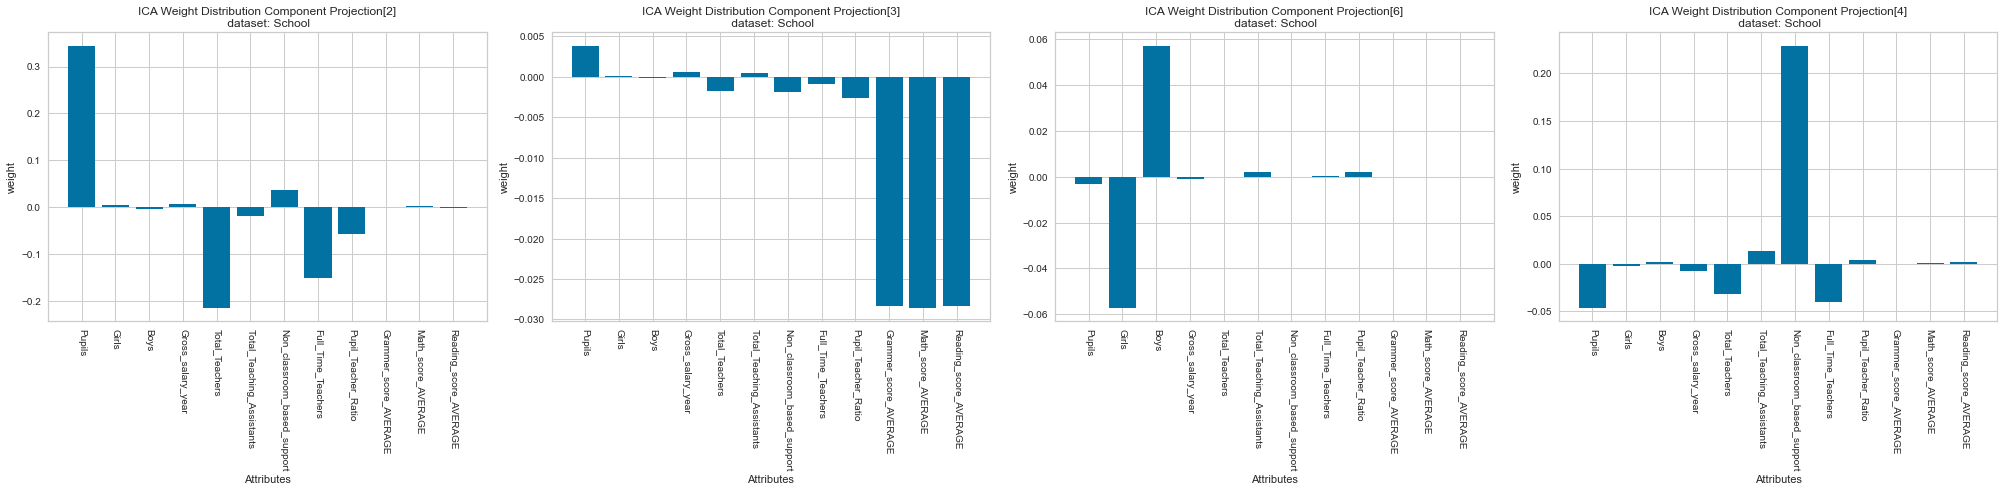

In [174]:
A_ , C_, C_filtered, mean_ = ica_research(X_train, 8, 4)
pd.DataFrame(C_filtered)
def plot_ica_dists(C_df,labels_list):
#     C_df.plot.bar()
   
    r,c = C_df.shape;
    #print (r)
    #print (c)
    #fig, ax_val = plt.subplots(2, r//2, figsize=(3*7,7))
    fig, ax_val = plt.subplots(1, r, figsize=(r*7,7))
    ax = ax_val if type(ax_val) == np.ndarray else [ax_val]
    for i in range(r):
        ax[i].bar( C_df.columns, C_df.iloc[i,:].values)
        ax[i].set_xlabel('Attributes')
        ax[i].set_xticks(C_df.columns)
        ax[i].set_xticklabels(labels_list)
        ax[i].tick_params(axis='x', labelrotation = -90)
        ax[i].set_ylabel('weight')
        ax[i].set_title(f"ICA Weight Distribution Component Projection[{C_df.index[i]}]\n dataset: School")
    fig.tight_layout()
    plt.show()

plot_ica_dists(C_filtered, LABELS)


## Randomized Projections

In [175]:
rs = [0, 77, 888, 5678, 98765, 543216, 123456789]
ks = [5,8,10,12,15,18,20]
ks = range(2,21)
def find_rand_proj(ks=ks,X=X):
    results = []
    for k in ks:
        error = 0
        for i in rs:
            gauRP = GaussianRandomProjection(random_state=i,n_components=k)

            gau = gauRP.fit_transform(X)
            
            X_transformed_large = gauRP.fit_transform(X)
            error += mean_squared_error(np.dot(gau,gauRP.components_), X)
        results.append(error/k)
    return results

In [176]:
randp_result = find_rand_proj()

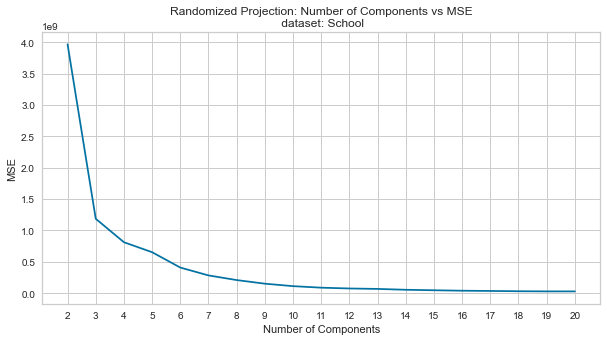

In [177]:
plt.title('Randomized Projection: Number of Components vs MSE\n dataset: School')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.xticks(range(len(ks)),ks)
plt.plot(randp_result)

eps=0.100000 and n_samples=6913 lead to a target dimension of 7578 which is larger than the original space with n_features=12
Optimal no. of components as per GRP: 5


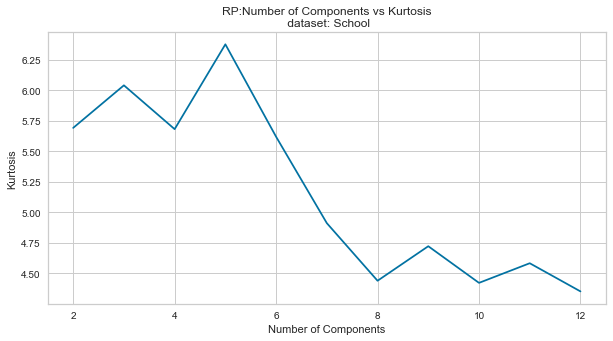

In [18]:
# Random Projections (Initial Try)
initial_features_n = len(X_train[0])
try:
  proj_grp = random_projection.GaussianRandomProjection(random_state=7)
  X_transformed = proj_grp.fit_transform(X_train)
except Exception as e:
  print(e)

kurtosis_grp = []
random_states = [0, 77, 888, 5678, 98765]
for dimension in range(2, initial_features_n + 1):
  k_vals_grp = []
  for rng in random_states:
    for iter in range(500):
          grp = random_projection.GaussianRandomProjection(n_components=dimension, random_state=7)
          grp_x_transform = grp.fit_transform(X_train)
          kurtosis_vals = kurtosis(grp_x_transform)
          k_vals_grp.append(kurtosis_vals)
  kurtosis_grp.append(np.mean(k_vals_grp))
optimal_features_grp = np.argmax(kurtosis_grp) + 2
print('Optimal no. of components as per GRP:', optimal_features_grp)

plt.title("RP:Number of Components vs Kurtosis\n dataset: School")
plt.xlabel('Number of Components')
plt.ylabel('Kurtosis')
plt.plot(range(2, initial_features_n + 1), kurtosis_grp)
plt.grid(True)
plt.show()


In [19]:
k_vals = []
reconstruction_error = []

for f_n in range(2, initial_features_n + 1):
    ica = FastICA(n_components=f_n, max_iter=10000, random_state=0, tol=1.5)
    ica_x_transformed = ica.fit_transform(X_train)
    #kurtosis_vals = kurtosis(ica_x_transformed)
    #k_vals.append(np.mean(kurtosis_vals))
    tmp = pd.DataFrame(ica_x_transformed)
    tmp = tmp.kurt(axis=0)
    k_vals.append(tmp.abs().mean())


    x_projected = ica.inverse_transform(ica_x_transformed)

for dimension in range(2, initial_features_n + 1):
  proj_grp = random_projection.GaussianRandomProjection(n_components=dimension, random_state=7)
  proj_grp.fit(X_train)
  components =  proj_grp.components_ # shape=(5, 11) 
  p_inverse = np.linalg.pinv(components.T) # shape=(5, 11) 

  reduced_data = proj_grp.transform(X_train) 
  reconstructed= reduced_data.dot(p_inverse)  
  #print("reduced_data -",reduced_data.shape, "  reconstructed -", reconstructed.shape)
  reconstruction_error.append(mean_squared_error(X_train, reconstructed))
  
  if(dimension == optimal_features_grp):
    chosen_error = ((X_train - x_projected) ** 2).mean()

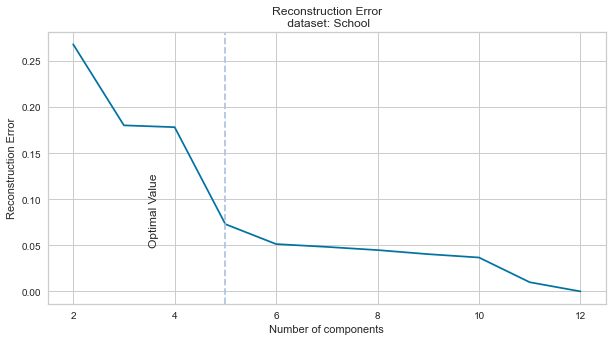

In [20]:
plt.plot(range(2, initial_features_n+1), reconstruction_error)
plt.axvline(optimal_features_grp, linestyle='--', color="lightsteelblue")
plt.text(optimal_features_grp-1.5, 0.05,'Optimal Value', rotation=90)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error\n dataset: School')
plt.grid(True)
plt.show()


In [178]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstruction_error(projections, x):
    w = projections.components_
    if sps.issparse(w):
        w = w.todense()
    p = pinv(w)
    reconstructed = ((p@w)@(x.T)).T  # Unproject projected data
    
    errors = mean_squared_error(x,reconstructed)

    return np.nanmean(errors)

def rca_research(X, title):
    dims = range(2, X.shape[1] + 1)
    recon_dict = defaultdict(dict)

    #r_states = [89143, 92, 1081244453, 8772, 212]
    #r_states = [0, 77, 888, 5678, 98765, 543216, 123456789]
    #r_states = [888, 5678, 98765, 543216, 123456789]
    r_states = [0, 77, 888, 5678, 98765, 543216, 6789432, 98273615, 123456789, 7]
    i = 0
    for r,dim in product(r_states,dims):
        rp = RCA(random_state=r, n_components=dim)
        rp.fit(X)
        recon_dict[dim][i%len(r_states)] = reconstruction_error(rp, X)
        i += 1
        
    tmp = pd.DataFrame(recon_dict).T
    print(tmp)
    mean_recon_df = tmp.mean(axis=1)
    mean_recon = mean_recon_df.tolist()
    std_recon = tmp.std(axis=1).tolist()
    
    print("*** reconstruction MSE***")
    print(mean_recon_df)
    


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'C0-')
    ax1.set_xlabel('Number of Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Error', color='C0')
    ax1.tick_params('y', colors='C0')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, linestyle='--', color='darkorange', linewidth=0.75)
    ax2.set_ylabel('STD Reconstruction Error', color='darkorange' )
    ax2.tick_params('y', colors='darkorange')
    plt.grid(False)

    plt.title("Random Components: 10 Restarts \n"+ title)
    fig.tight_layout()
    plt.show()

In [179]:
def rp(X, dim, r_state=7):
    rp = RCA(random_state=r_state, n_components=dim)
    fitted = rp.fit(X)
    X_rca_projected = rp.transform(X)
    return pd.DataFrame(X_rca_projected)

               0         1         2             3         4         5  \
2   2.135897e-01  0.220084  0.226739  2.351268e-01  0.279819  0.273156   
3   2.637004e-01  0.232114  0.226788  1.810993e-01  0.190402  0.194409   
4   1.527875e-01  0.222047  0.148234  1.392571e-01  0.197746  0.209935   
5   1.336206e-01  0.102194  0.179248  2.040558e-01  0.213717  0.159220   
6   1.188591e-01  0.101975  0.098857  1.548744e-01  0.156181  0.183435   
7   1.712413e-01  0.237689  0.086104  8.333832e-02  0.126243  0.153667   
8   1.522009e-01  0.164369  0.097511  7.200505e-02  0.055810  0.160160   
9   3.693154e-02  0.082258  0.132054  1.778679e-01  0.027452  0.058093   
10  9.283344e-03  0.022185  0.066023  9.376069e-02  0.048546  0.012594   
11  1.299248e-02  0.009283  0.012851  5.315209e-02  0.072112  0.005217   
12  2.805357e-30  0.012992  0.004513  1.005707e-30  0.048712  0.009014   

               6             7             8         9  
2   2.413734e-01  2.261177e-01  1.348769e-01  0.254900

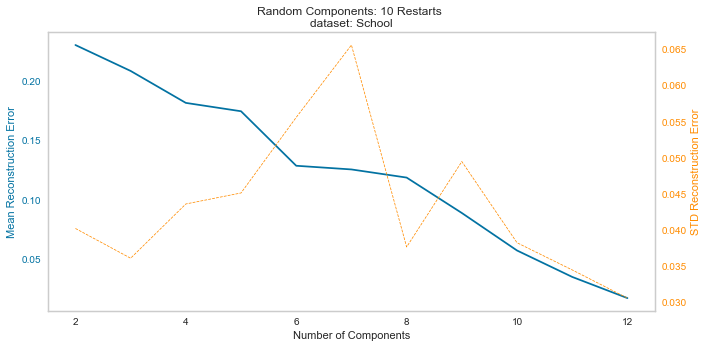

In [180]:
rca_research(X_train, 'dataset: School')

## Random Forest

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=7)
clf.fit(X_train, y_train)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_importance_sorted_idx
clf.feature_importances_[tree_importance_sorted_idx[-7:]]

array([0.02832232, 0.06479247, 0.07730152, 0.11241617, 0.15260214,
       0.23257355, 0.26036216])

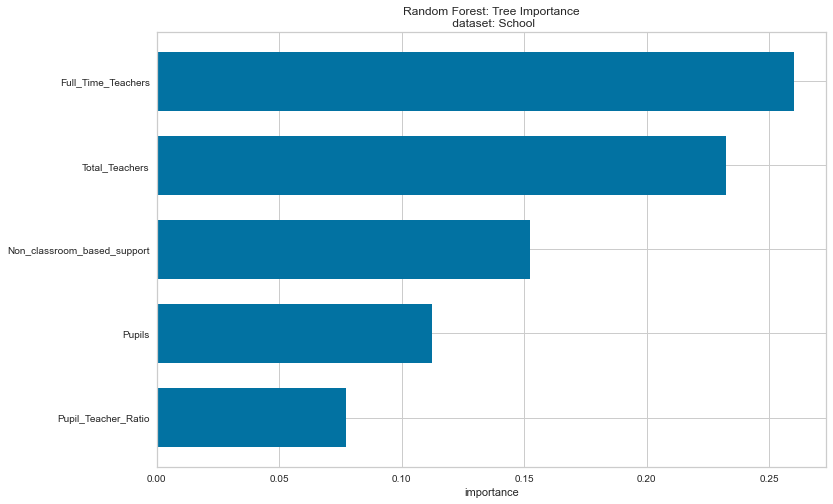

In [22]:
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.barh(tree_indices[-5:],
         clf.feature_importances_[tree_importance_sorted_idx[-5:]], height=0.7)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx][-5:])
ax1.set_yticks(tree_indices[-5:])
ax1.set_xlabel('importance')
plt.title('Random Forest: Tree Importance\n dataset: School')
plt.show()

In [183]:
def rfc_research(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=7, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_
        return fs
        
def rfc(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=7, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_
        indexes_found = np.where(fs >= 0.1)
        #print("index:",indexes_found[0])
        
        X_reduced = pd.DataFrame(X)
        #print("X_reduced",X_reduced)
        filter_columns = [list(X_reduced.columns)[i] for i in indexes_found[0]] 
        #print(filter_columns)
        X_reduced = X_reduced.filter(filter_columns, axis=1)
        #print(X_reduced)
        
        return X_reduced

In [184]:
#Research for Random Forest
important = rfc_research(X_train, y_train)
important_df = pd.DataFrame(columns=LABELS)
df_length = len(important_df)
important_df.loc[df_length] = important
print("*** importance ***:")
print(pd.Series(important))

print(rfc(X_train, y_train))

*** importance ***:
0     0.099968
1     0.064921
2     0.058836
3     0.063182
4     0.105268
5     0.192040
6     0.084556
7     0.140574
8     0.106993
9     0.028354
10    0.028379
11    0.026928
dtype: float64
             4         5         7      8
0     0.201183  0.069565  0.204406  0.280
1     0.153846  0.086957  0.074663  0.248
2     0.047337  0.147826  0.033660  0.368
3     0.437870  0.260870  0.446144  0.262
4     0.106509  0.147826  0.100979  0.496
...        ...       ...       ...    ...
6908  0.177515  0.304348  0.185435  0.484
6909  0.059172  0.069565  0.063647  0.396
6910  0.136095  0.200000  0.132803  0.310
6911  0.195266  0.434783  0.184823  0.412
6912  0.065089  0.208696  0.063647  0.394

[6913 rows x 4 columns]


# Projections

In [196]:
print(f"\n---- RUNNING PCA -------")
X_pca_proj = pca(X_train, 0.9, 0.02)

print(f"---- RUNNING ICA -------")
X_ica_proj = ica_max_kurtosis(X_train ,4, dim=8)

print(f"\n---- RUNNING RP -------")
r_states = [0, 77, 888, 5678, 98765, 543216, 6789432, 98273615, 123456789, 7]
X_rp_proj = []
for r in r_states:
    X_rp = rp(X_train, 9, r)
    X_rp_proj.append(X_rp)

print(f"\n---- RUNNING Random Forest RFC -------")
X_rfc_proj = rfc(X_train,y_train)

print(f"Shapes for rfc: {X_rfc_proj.shape} ")


---- RUNNING PCA -------
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.089568          0.465541  24.881646
2      0.059796          0.310797  20.330063
3      0.021811          0.113363  12.278207
4      0.008332          0.043308   7.588991
Threshold PCA components variance >= [0.02%]
   pca_stats_df  e-variance-ratio      eigen
1      0.089568          0.465541  24.881646
2      0.059796          0.310797  20.330063
3      0.021811          0.113363  12.278207
---- RUNNING ICA -------
Top-4 Max Kurtosis -- 
2    38.776912
3    33.834487
6    15.669273
4    13.869148
dtype: float64
Int64Index([2, 3, 6, 4], dtype='int64')

---- RUNNING RP -------

---- RUNNING Random Forest RFC -------
Shapes for rfc: (6913, 4) 


## Kmeans with Projections

In [197]:
print("Starting PCA scores")
scores_df_pca = get_kmean_scores(X_pca_proj, y_train, 10)

print("Starting ICA score")
scores_df_ica = get_kmean_scores(X_ica_proj, y_train, 10)

scores_df_rp = []
for i in range(len(X_rp_proj)):
    print(f"Starting RP scores [{i}]")
    scores_df_rp.append(get_kmean_scores(X_rp_proj[i], y_train, 10))
    
print("Starting RFC scores")
scores_df_rfc = get_kmean_scores(X_rfc_proj,  y_train, 10)

Starting PCA scores
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting ICA score
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [0]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [1]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [2]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [3]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10

In [187]:
def merge_scores_df_list(scores_df_list):
    scores_all_df = pd.DataFrame(scores_df_list[0])
    for i in range(1,len(scores_df_list)):
        scores_all_df += scores_df_list[i]
    
    scores_all_df = scores_all_df / len(scores_df_list)
    return scores_all_df

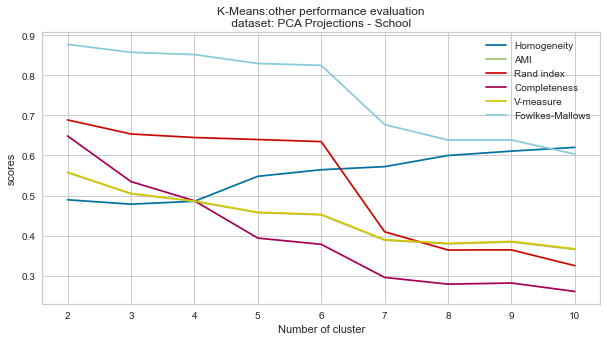

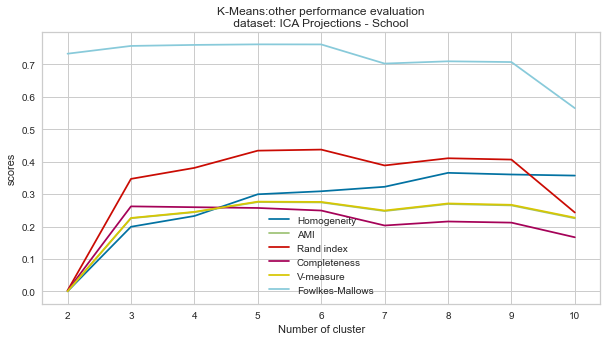

(9, 7), (9, 7)


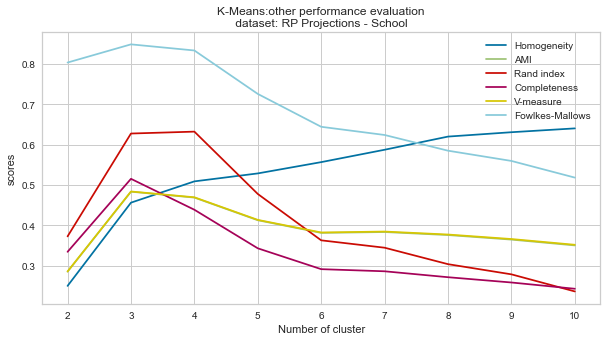

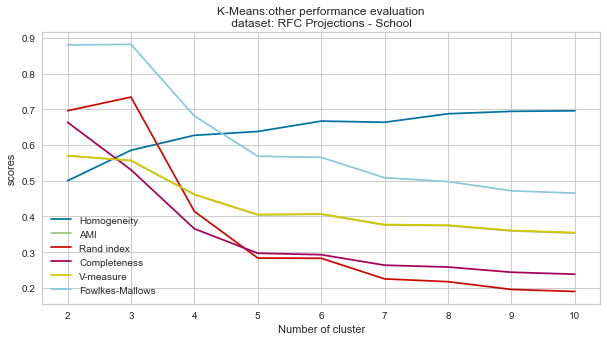

In [198]:
plot_elbow_kmeans(scores_df_pca, 'PCA Projections - School')

plot_elbow_kmeans(scores_df_ica, 'ICA Projections - School')

scores_all_df_rp = merge_scores_df_list(scores_df_rp)
print(f"{scores_all_df_rp.shape}, {scores_df_rp[0].shape}")
plot_elbow_kmeans(scores_all_df_rp, 'RP Projections - School')

plot_elbow_kmeans(scores_df_rfc, 'RFC Projections - School')


In [189]:
def plot_km_pairwise(X, N, title):
    
    km = KMeans(n_clusters=N,random_state=7, max_iter=10000)
    km.fit(X)
    pred_clusters = km.predict(X)


    filtred_df = X.copy()  
    x_vars = filtred_df.columns     
    filtred_df['pred'] = pred_clusters  
    y_vars = filtred_df.columns[0:2]
    #print("y_vars:",y_vars)
    
    ax = sns.PairGrid(filtred_df, hue="pred", x_vars=x_vars, y_vars=y_vars)
    #label_list = ["SSLfinal_State", "Request_URL", "Domain_registeration_length", "web_traffic", "age_of_domain", "URL_of_Anchor"]
    #ax.set_xticklabels(label_list)
    ax.map_diag(sns.histplot)
    ax.map_offdiag(sns.scatterplot)
    ax.add_legend()
    ax.fig.suptitle("%s, Kmeans, k-cluster = %d"%(title,N), y=1.08)

### PCA

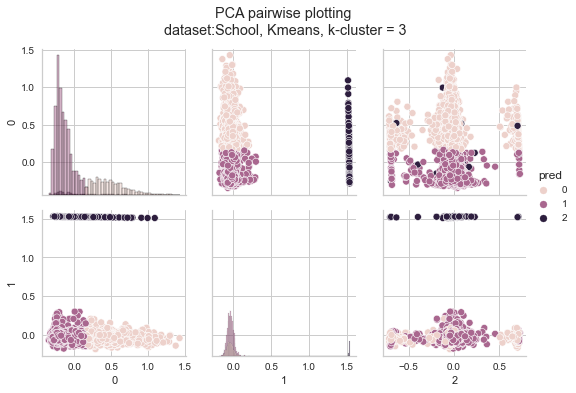

In [190]:
plot_km_pairwise(X_pca_proj, 3, 'PCA pairwise plotting\n dataset:School')

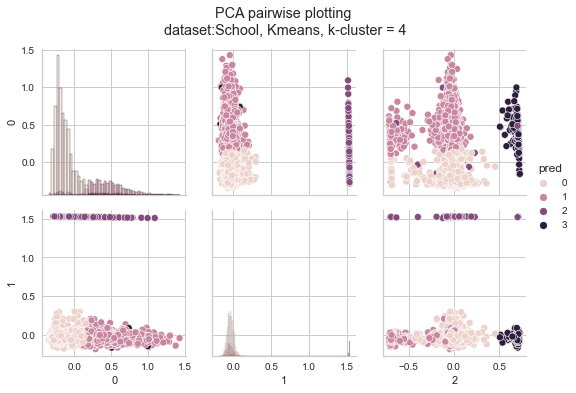

In [192]:
plot_km_pairwise(X_pca_proj, 4, 'PCA pairwise plotting\n dataset:School')

### ICA

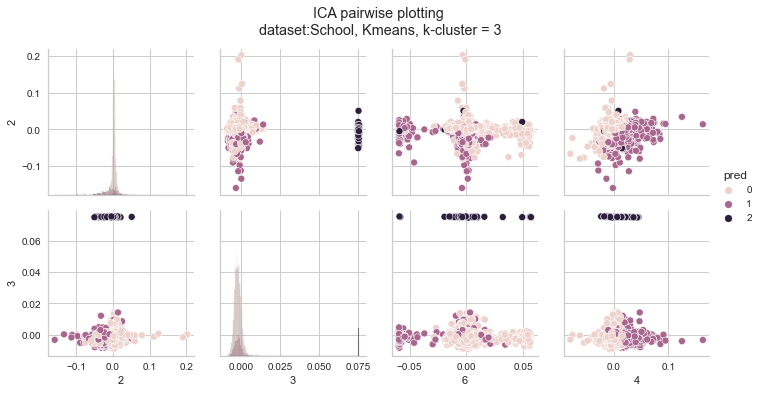

In [193]:
plot_km_pairwise(X_ica_proj, 3, 'ICA pairwise plotting\n dataset:School')

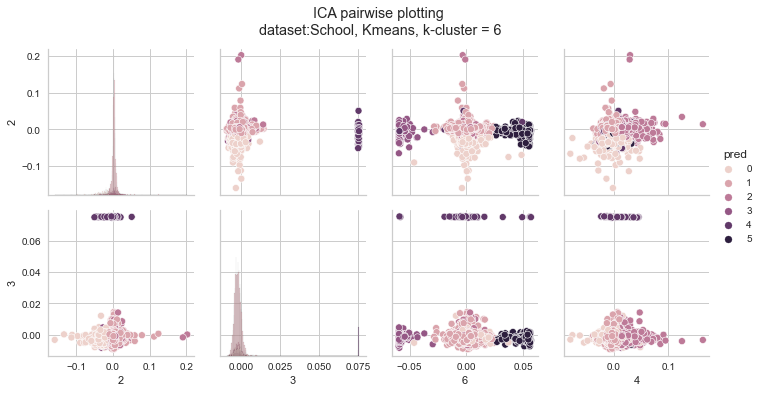

In [194]:
plot_km_pairwise(X_ica_proj, 6, 'ICA pairwise plotting\n dataset:School')

### RP

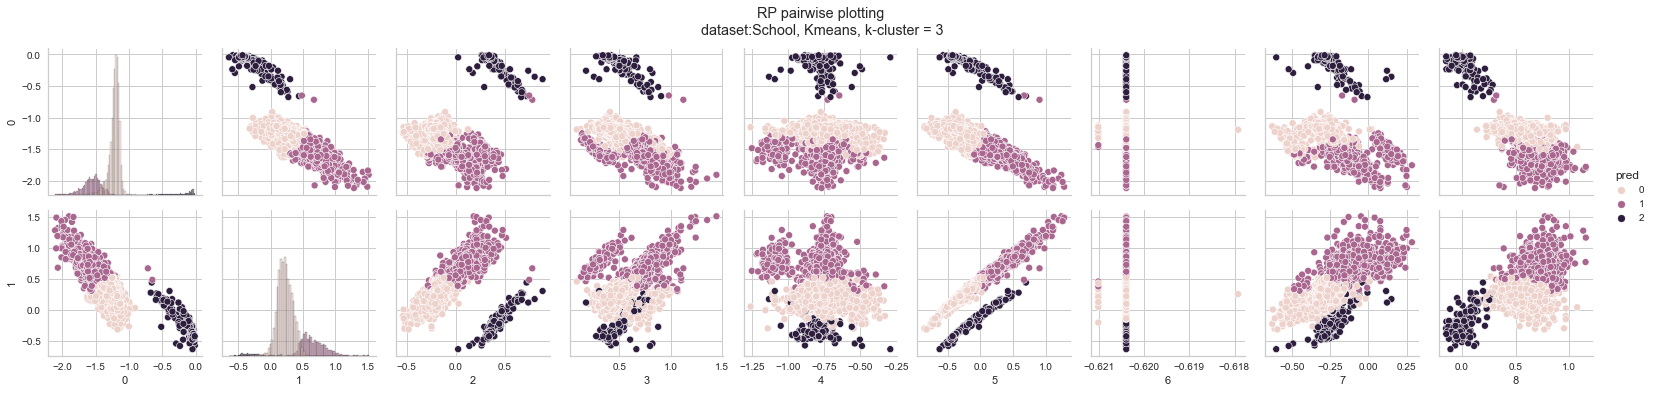

In [199]:
plot_km_pairwise(X_rp_proj[0], 3, 'RP pairwise plotting\n dataset:School')

### RFC

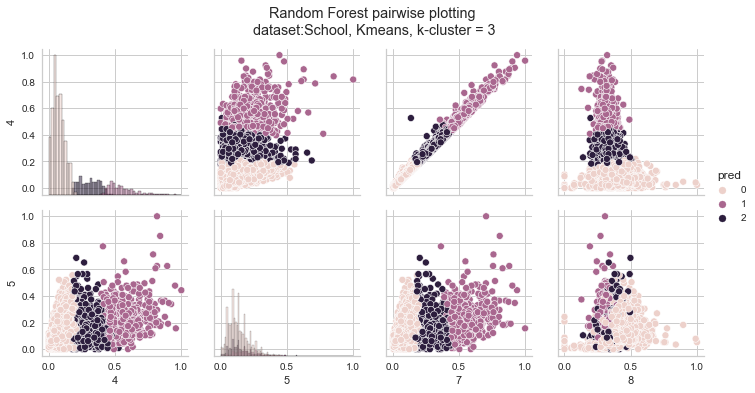

In [200]:
plot_km_pairwise(X_rfc_proj, 3, 'Random Forest pairwise plotting\n dataset:School')

## EM with Projections

In [204]:
print("Starting PCA scores")
scores_df_pca = get_em_scores(X_pca_proj, y_train, 10)

print("Starting ICA scores")
scores_df_ica = get_em_scores(X_ica_proj, y_train, 10)

scores_df_rp = []
for i in range(len(X_rp_proj)):
    print(f"Starting RP scores [{i}]")
    scores_df_rp.append(get_em_scores(X_rp_proj[i], y_train, 10))
print("Starting RFC scores")
scores_df_rfc = get_em_scores(X_rfc_proj, y_train, 10)

Starting PCA scores
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting ICA scores
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [0]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [1]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [2]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting RP scores [3]
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 1

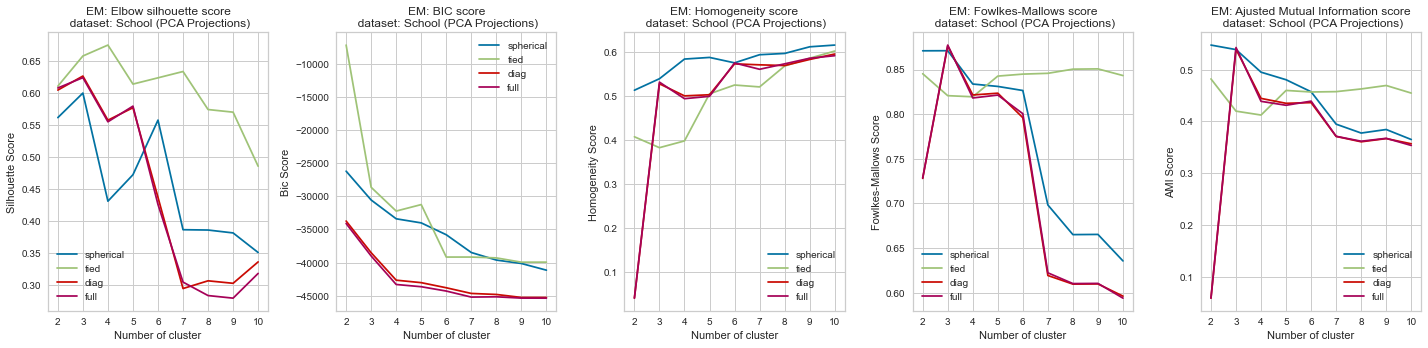

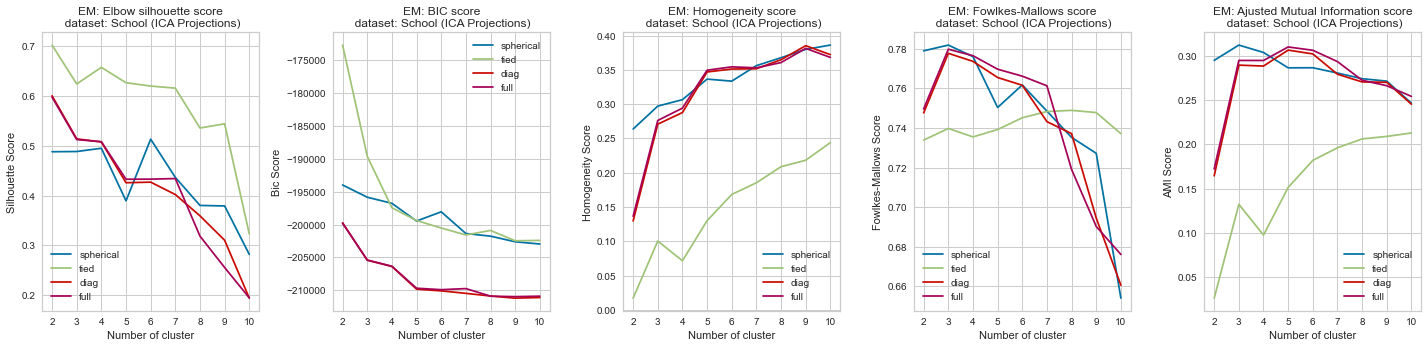

(9, 21), (9, 21)


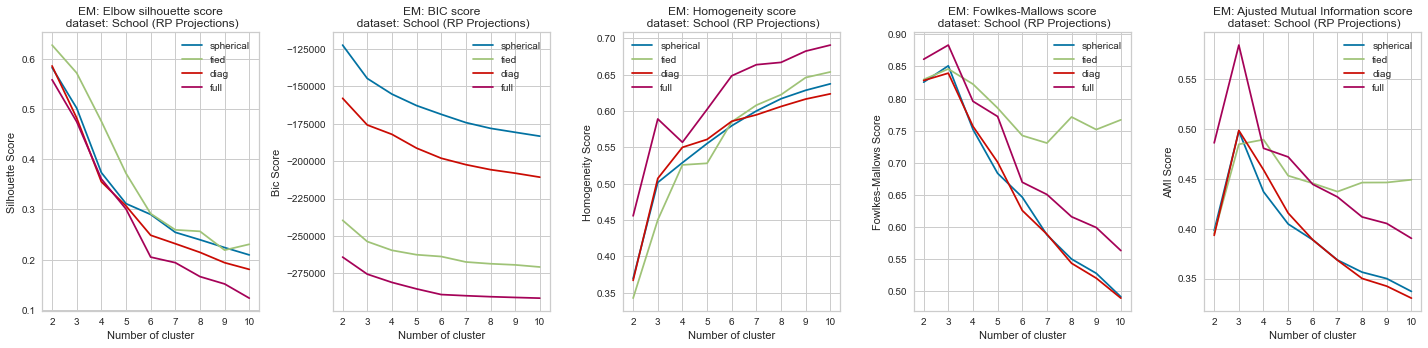

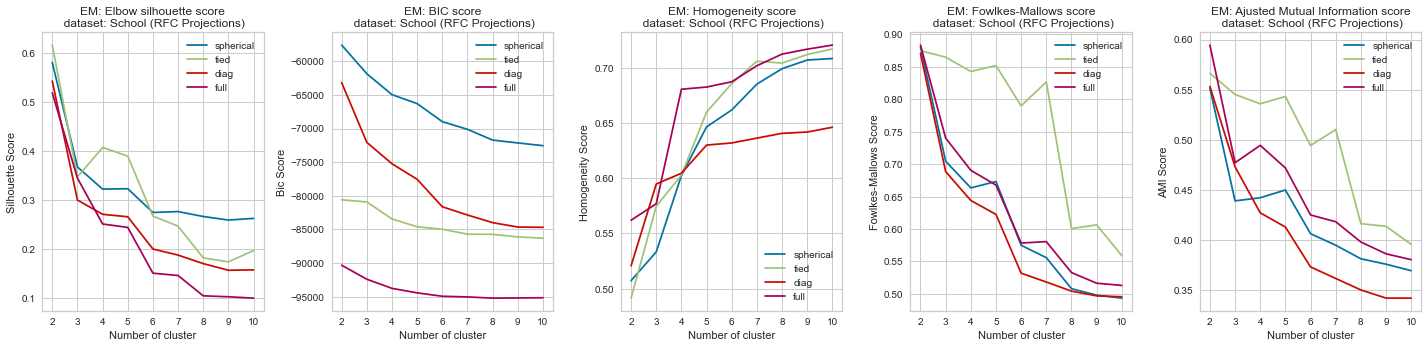

In [205]:
plot_elbow_em(scores_df_pca, 'School (PCA Projections)')#, face_color='#FF8C00')

plot_elbow_em(scores_df_ica, 'School (ICA Projections)')#, face_color='#ffffd4')

scores_all_df_rp = merge_scores_df_list(scores_df_rp)
print(f"{scores_all_df_rp.shape}, {scores_df_rp[0].shape}")
plot_elbow_em(scores_all_df_rp, 'School (RP Projections)')#, face_color='#f6cefc')

plot_elbow_em(scores_df_rfc, 'School (RFC Projections)')#, face_color='#cafffb')


In [206]:
def plot_em_pairwise(X, N, cv_type, title):
    
    gmm = GMM(n_components=N, covariance_type=cv_type, random_state=7)
    gmm.fit(X)
    pred_clusters = gmm.predict(X)


    filtred_df = pd.DataFrame(X)
 
    x_vars = filtred_df.columns    
    filtred_df['pred'] = pred_clusters

    y_vars = filtred_df.columns[0:2]
    ax = sns.PairGrid(filtred_df, hue="pred", x_vars=x_vars, y_vars=y_vars)
    ax.map_diag(sns.histplot)
    ax.map_offdiag(sns.scatterplot)
    ax.add_legend()
    ax.fig.suptitle("%s, EM, k-cluster = %d"%(title,N), y=1.08)

### PCA

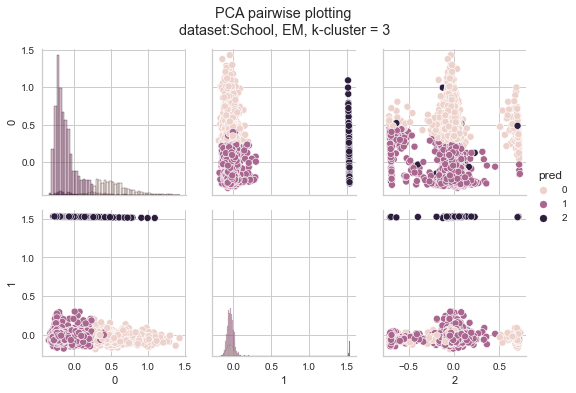

In [207]:
plot_em_pairwise(X_pca_proj, 3, 'tied','PCA pairwise plotting\n dataset:School')

### ICA

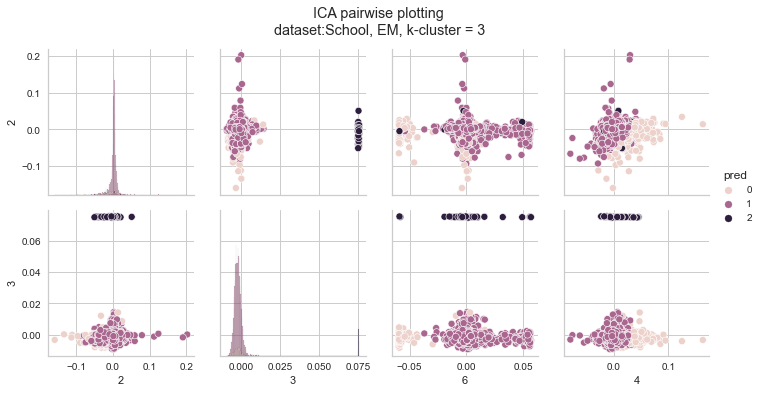

In [208]:
plot_em_pairwise(X_ica_proj, 3, 'tied','ICA pairwise plotting\n dataset:School')

### RP

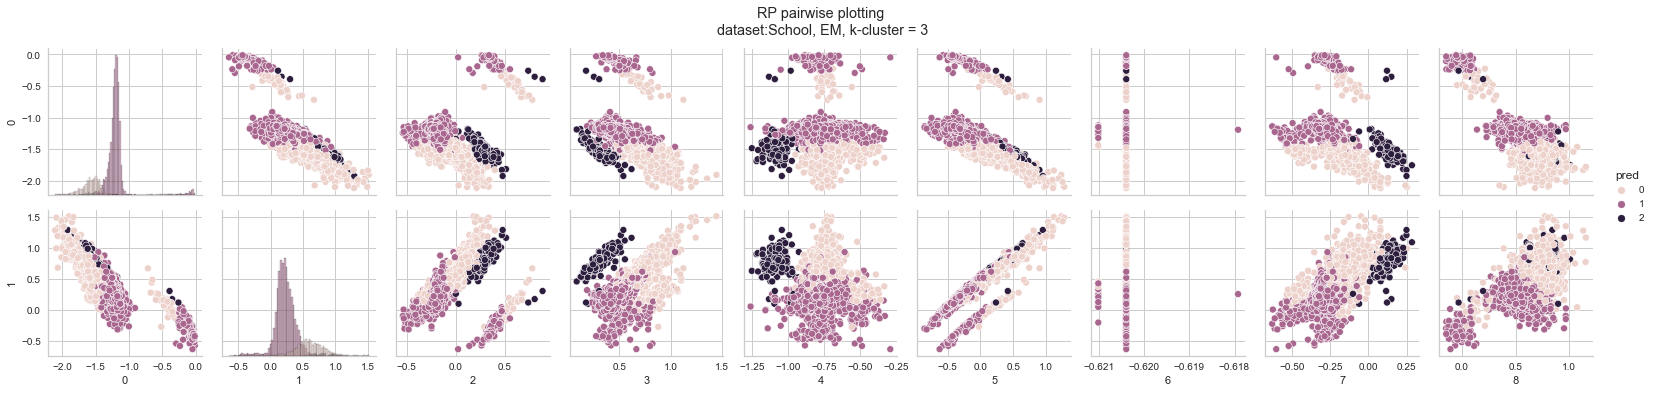

In [209]:
plot_em_pairwise(X_rp_proj[0], 3, 'tied','RP pairwise plotting\n dataset:School')

### RFC

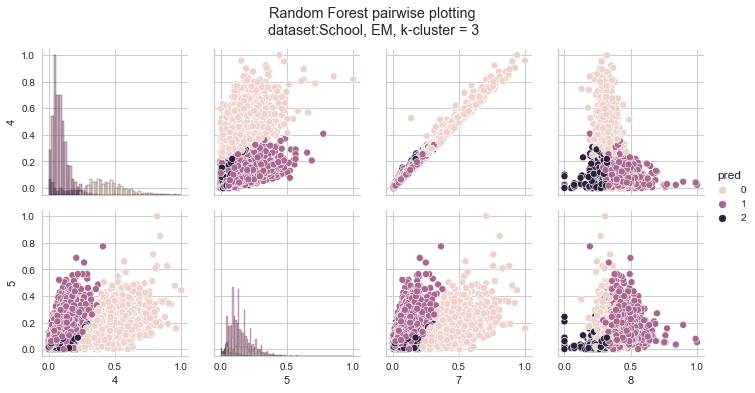

In [210]:
plot_em_pairwise(X_rfc_proj, 3, 'tied','Random Forest pairwise plotting\n dataset:School')